In [1]:
import time
import os
import subprocess
import sys
sys.path.insert(1, '/home/jupyter/datasets/genformer')
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf

import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.models.aformer_atac as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers

import training_utils_atac as training_utils

from scipy import stats

import analysis.scripts.interval_and_plotting_utilities as utils

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
SEQUENCE_LENGTH=524288
resolution=4
num_bins = SEQUENCE_LENGTH // resolution

#with strategy.scope():

model = aformer.aformer(kernel_transformation='relu_kernel_transformation',
                        dropout_rate=0.20,
                        pointwise_dropout_rate=0.10,
                        input_length=524288,
                        output_length=4096,
                        final_output_length=896,
                        num_heads=8,
                        numerical_stabilizer=0.0000001,
                        nb_random_features=256,
                        max_seq_length=4096,
                        norm=True,
                        BN_momentum=0.90,
                        normalize = True,
                        num_transformer_layers=7,
                        final_point_scale=6,
                        filter_list_seq=[768,896,1024,1152,1280,1536],
                        filter_list_atac=[32,64],
                        tf_dropout_rate=0.01)


test = tf.ones((1,524288,4)),tf.ones((1,131072,1)),tf.ones((1,1629,1))#,tf.ones((1,1,1536))
model(test,training=False)
print('ran test input')
#model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_mm_rm_rat_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-18_12:37:42/iteration_24/saved_model")
#model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_262k_load-True_LR-0.01_T-7_D-0.3_2023-04-13_15:39:43/final/saved_model")
model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_524k_load-False_LR-0.0002_T-7_TF-True_2023-10-27_23:43:30/iteration_26/saved_model")
print('loaded weights')


chrom,start,stop = utils.resize_interval("chr10:5,977,276-5,978,845",524288)

TypeError: ('Keyword argument not understood:', 'synchronized')

In [ ]:
atac_arr = utils.return_atac_interval("/home/jupyter/datasets/processed_genformer_data/ATAC/Fetal_Adrenal_Neuron.bed.gz",
                         "chr10",start,stop,num_bins,resolution)

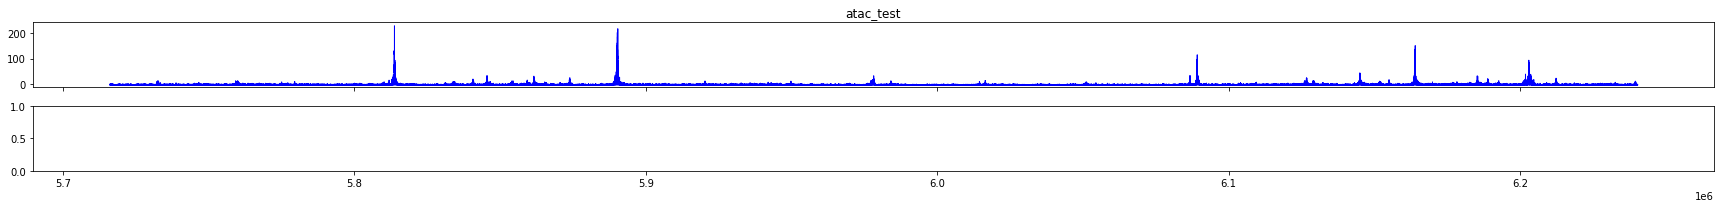

In [4]:
tracks={'atac_test': (atac_arr[:,0],'blue')}
utils.plot_tracks(tracks,start,stop)

In [9]:
atac_arr.shape

(131072, 1)

In [ ]:
def plot_tracks(tracks, start, end, height=1.5):
    fig, axes = plt.subplots(len(tracks)+1, 1, figsize=(24, height * (len(tracks)+1)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(start, end, num=len(y[0])), y[0],color=y[1])
        ax.set_title(title)
    #axes[-1].imshow(peaks, aspect = "auto", cmap="viridis")
    plt.tight_layout()